<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN3_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.layers import Dense,Flatten,Dropout
from keras.regularizers import l2

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    # Preprocess image for ResNet50 model
    image_rgb = preprocess_input(image_rgb)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define age group conversion
def age_to_range(age):
    return age // 3 # Convert ages to 3-year interval indices

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/drive/MyDrive/Dataset/part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, np.max(age_groups) + 1)

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (9931, 224, 224, 3)
Labels shape: (9931, 37)


In [9]:
def age_group_to_interval(group_index, interval=3):
    start = group_index * interval
    end = (group_index + 1) * interval - 1
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/drive/MyDrive/Dataset/part1/28_1_0_20...,27-29
1,/content/drive/MyDrive/Dataset/part1/35_0_0_20...,33-35
2,/content/drive/MyDrive/Dataset/part1/38_0_4_20...,36-38
3,/content/drive/MyDrive/Dataset/part1/50_1_0_20...,48-50
4,/content/drive/MyDrive/Dataset/part1/20_1_2_20...,18-20
5,/content/drive/MyDrive/Dataset/part1/35_0_4_20...,33-35
6,/content/drive/MyDrive/Dataset/part1/57_0_0_20...,57-59
7,/content/drive/MyDrive/Dataset/part1/51_0_0_20...,51-53
8,/content/drive/MyDrive/Dataset/part1/36_1_0_20...,36-38
9,/content/drive/MyDrive/Dataset/part1/39_0_0_20...,39-41


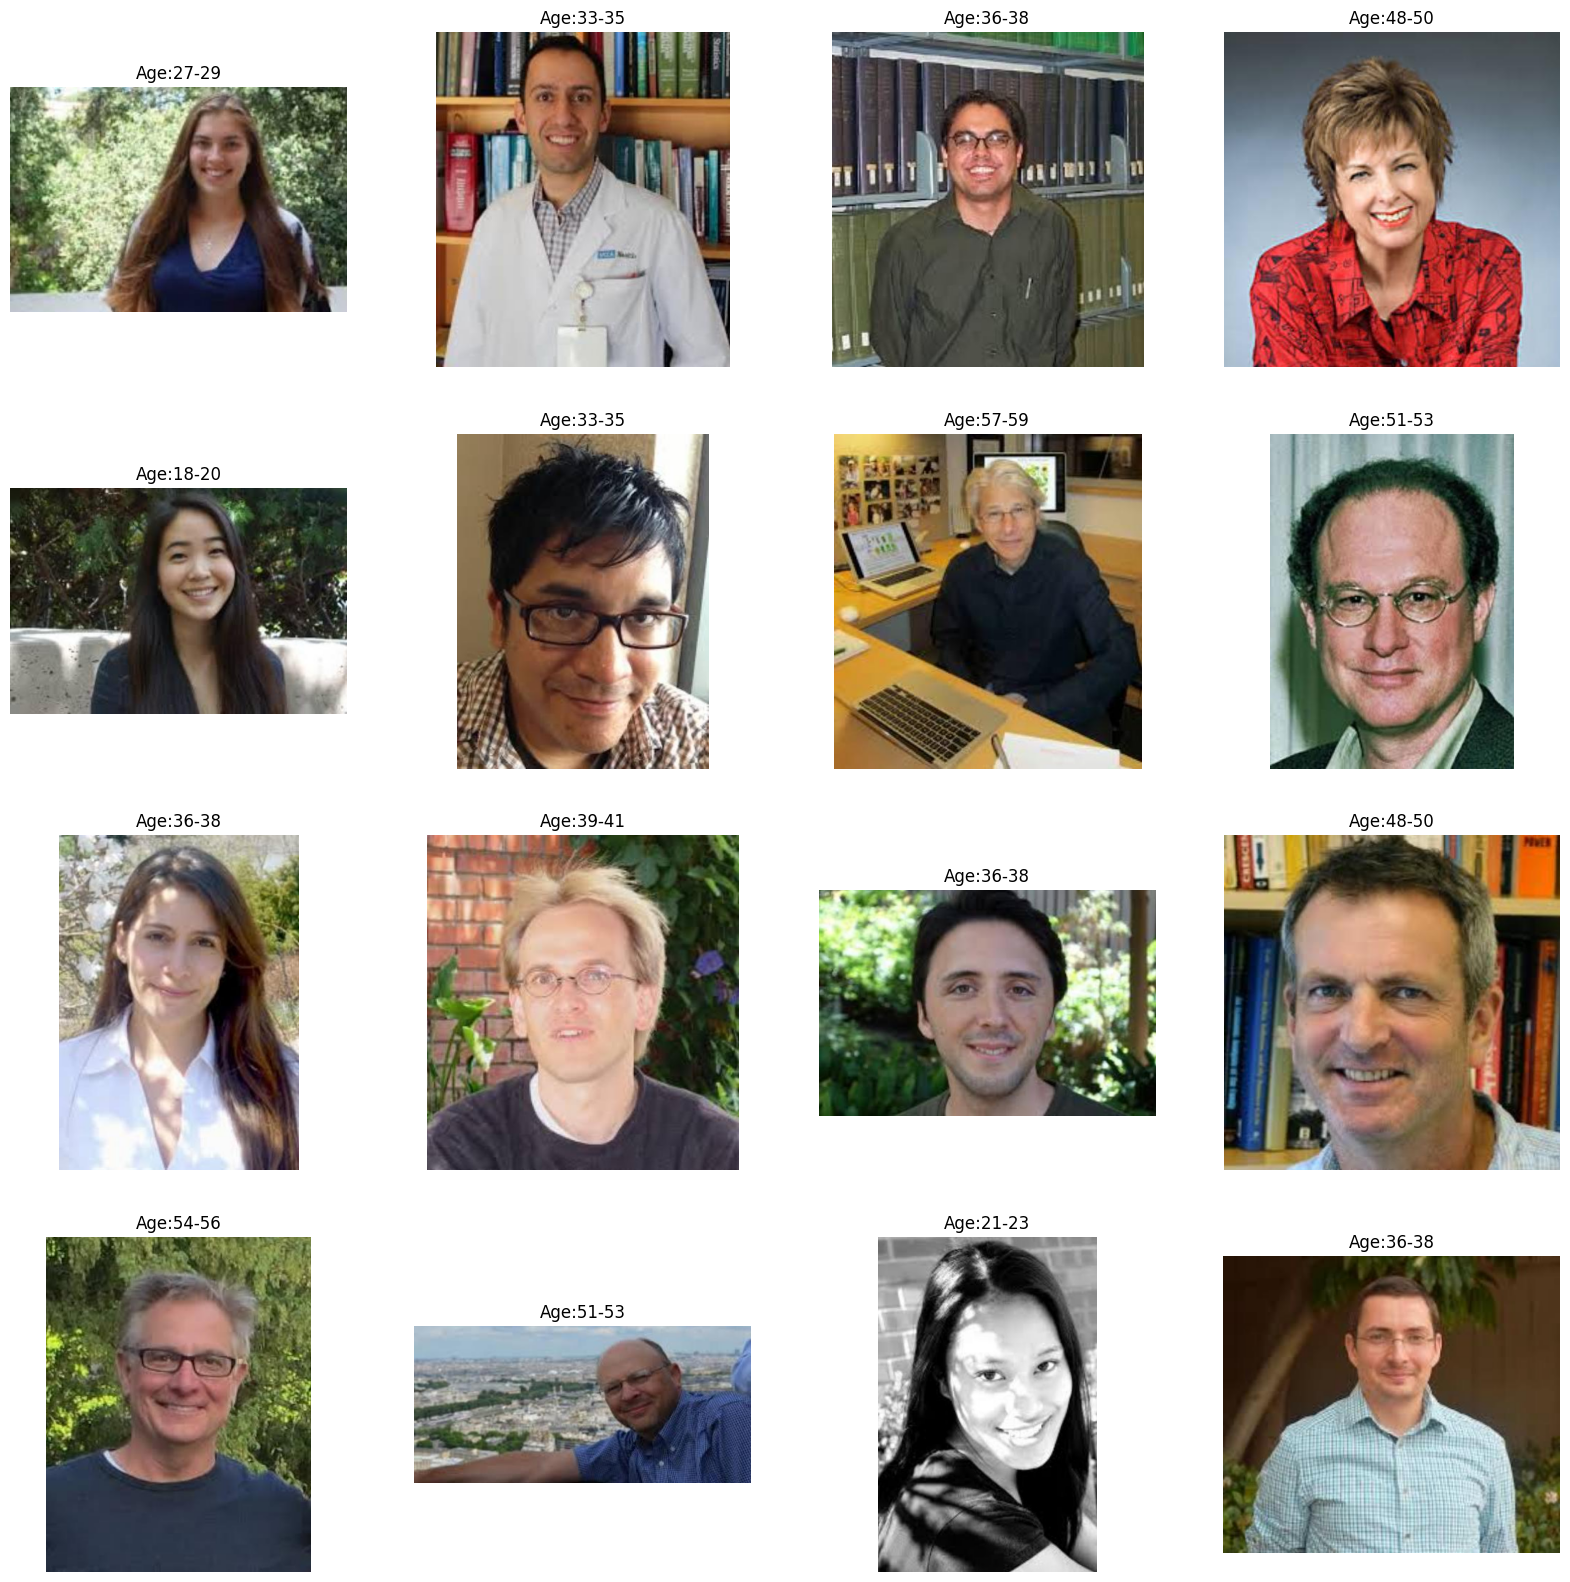

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

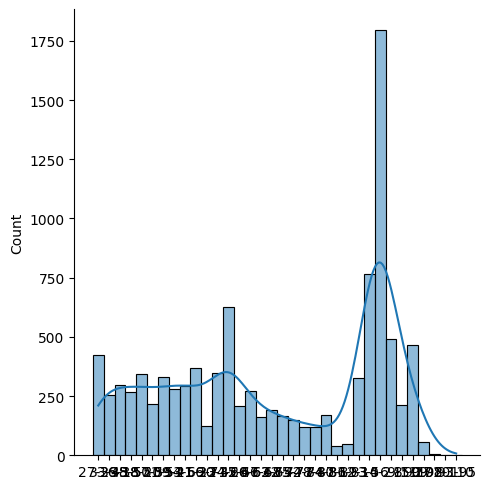

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [14]:
# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Prevent training already trained layers
for layer in base_model.layers:
  layer.trainable = False

# Add custom layers on top of the base model
#Add flatten layer
x = Flatten()(base_model.output)
#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(np.max(age_groups)+1, activation='softmax')(x)

#Create the model object
model = Model(inputs=base_model.input, outputs=prediction)

model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [15]:
# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics = ["accuracy"])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/D1_CNN3_A1.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [17]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[early_stopping, model_checkpoint],shuffle=False)


Epoch 1/60
199/199 [==============================] - ETA: 0s - loss: 11.1767 - accuracy: 0.1227
Epoch 1: val_accuracy improved from -inf to 0.22278, saving model to /content/drive/MyDrive/Dataset/D1_CNN3_A1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 65s 283ms/step - loss: 11.1767 - accuracy: 0.1227 - val_loss: 5.1729 - val_accuracy: 0.2228
Epoch 2/60
199/199 [==============================] - ETA: 0s - loss: 6.4475 - accuracy: 0.1912
Epoch 2: val_accuracy improved from 0.22278 to 0.24103, saving model to /content/drive/MyDrive/Dataset/D1_CNN3_A1.h5
199/199 [==============================] - 29s 144ms/step - loss: 6.4475 - accuracy: 0.1912 - val_loss: 5.0633 - val_accuracy: 0.2410
Epoch 3/60
199/199 [==============================] - ETA: 0s - loss: 5.6494 - accuracy: 0.2238
Epoch 3: val_accuracy did not improve from 0.24103
199/199 [==============================] - 25s 126ms/step - loss: 5.6494 - accuracy: 0.2238 - val_loss: 5.0122 - val_accuracy: 0.2297
Epoch 4/60
199/199 [==============================] - ETA: 0s - loss: 5.3485 - accuracy: 0.2423
Epoch 4: val_accuracy improved from 0.24103 to 0.24355, saving model to /content/drive/MyDrive/Dataset/D1_CNN3_A1.h5
199/199 [===============

In [18]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/D1_CNN3_A1.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


63/63 [==============================] - 7s 109ms/step - loss: 4.0617 - accuracy: 0.3010
Test Accuracy: 30.10%


In [19]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

63/63 [==============================] - 6s 96ms/step


In [20]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       379
           1       0.37      0.51      0.43       147
           2       0.23      0.22      0.22        91
           3       0.11      0.02      0.04        48
           4       0.28      0.19      0.22        59
           5       0.28      0.12      0.17        98
           6       0.07      0.04      0.05        74
           7       0.28      0.12      0.17        80
           8       0.19      0.29      0.23       125
           9       0.07      0.10      0.08        89
          10       0.07      0.09      0.08        64
          11       0.14      0.06      0.08        51
          12       0.07      0.09      0.08        56
          13       0.09      0.08      0.08        49
          14       0.11      0.05      0.07        37
          15       0.06      0.09      0.07        46
          16       0.09      0.18      0.12        57
          17       0.24    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.30
Precision: 0.28
Recall: 0.30
F1-score: 0.28


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Calculate accuracy for each class
class_accuracies = {}
for idx in range(np.max(age_groups) + 1):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[age_group_to_interval(idx)] = accuracy

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:520: R

In [23]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 0-2: 0.91
Accuracy for age range 3-5: 0.51
Accuracy for age range 6-8: 0.22
Accuracy for age range 9-11: 0.02
Accuracy for age range 12-14: 0.19
Accuracy for age range 15-17: 0.12
Accuracy for age range 18-20: 0.04
Accuracy for age range 21-23: 0.12
Accuracy for age range 24-26: 0.29
Accuracy for age range 27-29: 0.10
Accuracy for age range 30-32: 0.09
Accuracy for age range 33-35: 0.06
Accuracy for age range 36-38: 0.09
Accuracy for age range 39-41: 0.08
Accuracy for age range 42-44: 0.05
Accuracy for age range 45-47: 0.09
Accuracy for age range 48-50: 0.18
Accuracy for age range 51-53: 0.20
Accuracy for age range 54-56: 0.02
Accuracy for age range 57-59: 0.05
Accuracy for age range 60-62: 0.11
Accuracy for age range 63-65: 0.05
Accuracy for age range 66-68: 0.06
Accuracy for age range 69-71: 0.05
Accuracy for age range 72-74: 0.18
Accuracy for age range 75-77: 0.21
Accuracy for age range 78-80: 0.14
Accuracy for age range 81-83: 0.00
Accuracy for age range 84-8